# 1. Protein expression level prediction

![Pump](./images/protein_protein_interaction.png)

## Business context
    
Protein expression - the process, when hereditary information from the gene (DNA bases sequence) transfer to the final product - protein. Level of expression is protein quantity, transferred in the process. The higher the protein expression, the greater protein quantity arise in human cell's.   

### Task importance
    
There are many reasons to know protein expression level. For example, it helps scietists to develop new drugs and optimize it's process.   
    

## Dataset
    
Dataset is a protein interaction graph. A node - protein, protein interaction - edge. Level expression is known for each protein. Hereinbelow are the list of `edges`. Protein expression levels are splitted into `train` and `test`.

In [ ]:
import pandas as pd

DATA_RAW = "./data/raw/"
DATA_INTERIM = "./data/interim/"

In [2]:
# Graph edge's list

edges = pd.read_csv(DATA_RAW + "edges.csv")
# edges.to_csv(DATA_RAW + "edges.csv", index=False)
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [3]:
# Upload train dataset

train = pd.read_csv(DATA_RAW + "train.csv")
# train.to_csv(DATA_RAW + "train.csv", index=False)
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [4]:
# Upload test dataset

test = pd.read_csv(DATA_RAW + "test.csv")
# test.to_csv(DATA_RAW + "test.csv", index=False)
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


## Data science context
    
Predict protein expression level (`target`) based on datasets. `test` dataset has known `target`.

__Comments:__   

* Graph has one connected component. 
* Huge huns are deleted.
* Graph connection density is decreased.

    
### Metric

MSE    

# 2. Import

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from typing import Callable
import copy

import torch
from torch.optim import Adam
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.loader import RandomNodeLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data.data import Data
from torch_geometric.utils import from_networkx

C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\parshin_sa2\Miniconda3\envs\otus-graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Custom

In [2]:
from model import Model, test_model, my_plot, mse_loss

### Settings for beautifull plots

In [6]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


# 3. Global params

In [74]:
SEED = 42
TARGET = "target"

VAL_TRESH = 7000
TEST_TRESH = 8000
IS_SHUFFLE = True

NUM_EPOCH = 70 # 100
SAGE_HIDDEN = 64
LINEAR_HIDDEN = 32
DROPOUT = 0.5
LR = 0.001
WD = 5e-5
LOADER_PARTS = 6
AGG_METHOD = 'mean' # 'median' works very slow

# 4. EDA

In [8]:
all_nodes = pd.concat([train, test], axis=0).reset_index(drop=True)

In [9]:
display(edges.info())
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594174 entries, 0 to 594173
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   node_1  594174 non-null  int64
 1   node_2  594174 non-null  int64
dtypes: int64(2)
memory usage: 9.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  8000 non-null   float64
 1   node    8000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 125.1 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  2000 non-null   float64
 1   node    2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Num of links with neibour nodes


array([[<Axes: title={'center': 'node_2'}>]], dtype=object)

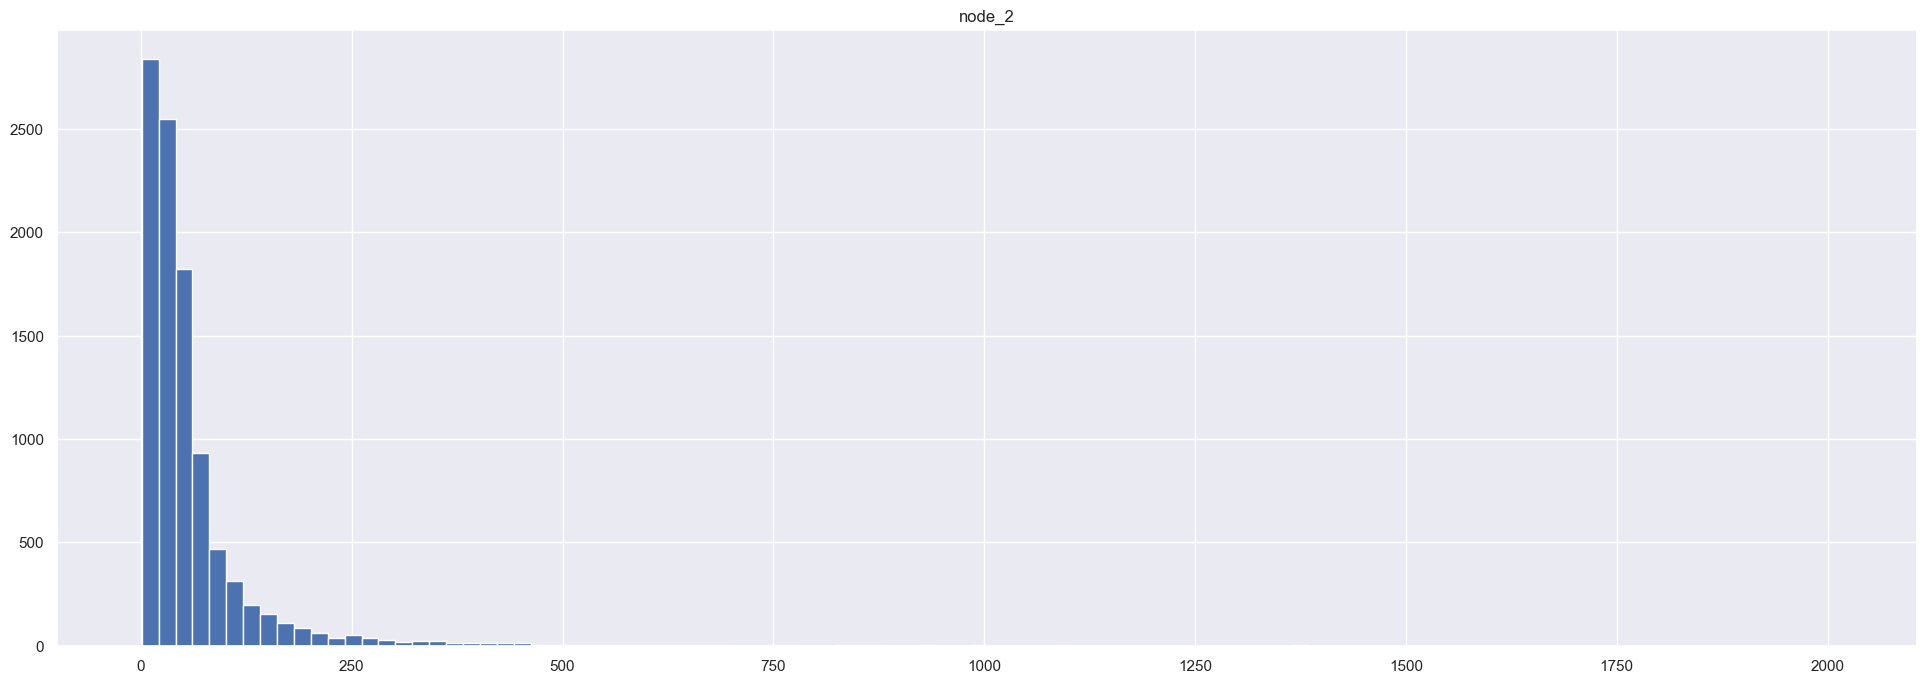

In [10]:
print("Num of links with neibour nodes")
edges.groupby("node_1").count().hist(bins=100)

Generally nodes have 0-250 edges.

(<Axes: >, <Axes: >)

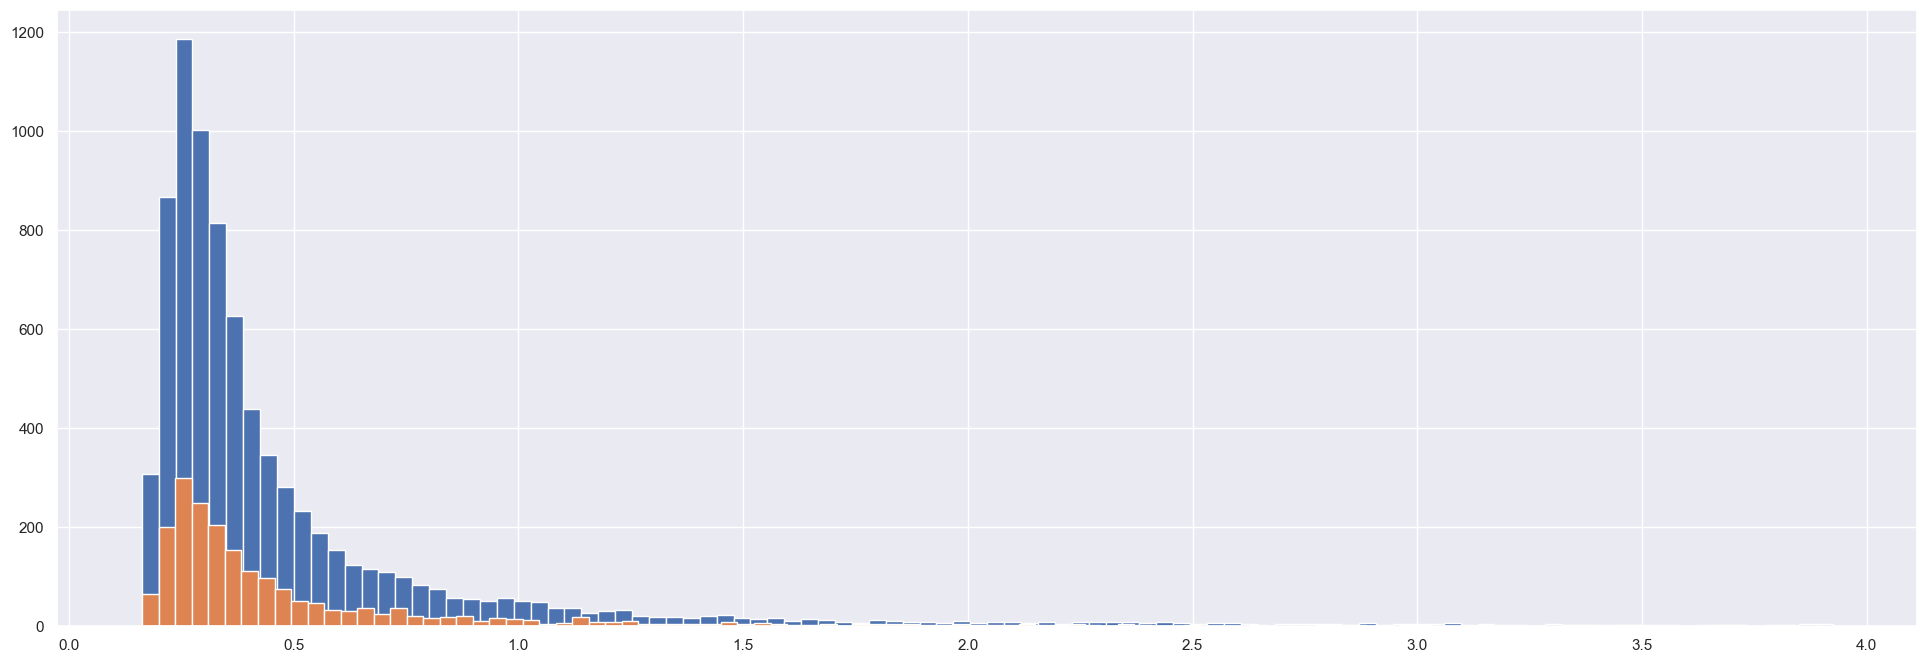

In [11]:
tresh_to_show = 4
train.loc[train[TARGET] < tresh_to_show, TARGET].hist(bins=100), test.loc[test[TARGET] < tresh_to_show, TARGET].hist(bins=100)

In [12]:
train.describe(), test.describe()

(            target          node
 count  8000.000000   8000.000000
 mean      0.531021  13278.330125
 std       0.673008   8750.366724
 min       0.162075      0.000000
 25%       0.263916   5207.750000
 50%       0.339945  12825.500000
 75%       0.521007  20751.250000
 max      12.216818  31204.000000,
             target        node
 count  2000.000000   2000.0000
 mean      0.569324  13103.7940
 std       0.867445   8726.0327
 min       0.163269      8.0000
 25%       0.266700   5314.7500
 50%       0.341745  12341.0000
 75%       0.529549  20662.5000
 max      15.098584  31120.0000)

* The target function is asymmetric. It could ne fixed by log transformation.
* `train` and `test` datasets have the same values range and the distribution form are similar. Therefore train-test split is correct.

(<Axes: >, <Axes: >)

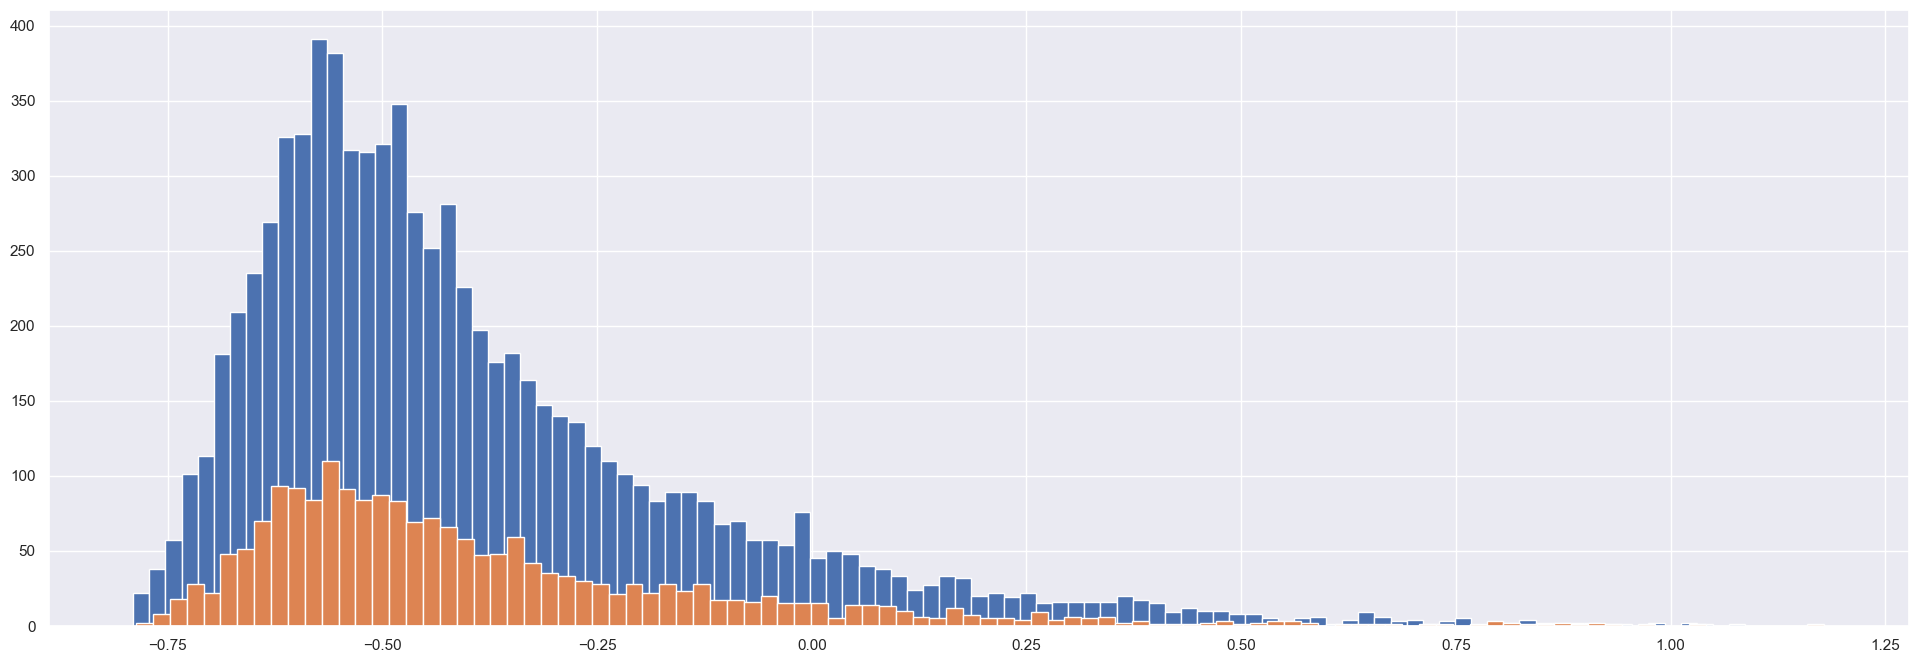

In [13]:
np.log10(train.loc[:, TARGET]).hist(bins=100), np.log10(test.loc[:, TARGET]).hist(bins=100)

### Explore graph by NetworkX

In [14]:
all_nodes.describe()

,target,node
count,10000.000000,10000.000000
mean,0.538682,13243.422900
std,0.716247,8745.348163
min,0.162075,0.000000
25%,0.264226,5240.500000
50%,0.340447,12738.000000
75%,0.522759,20736.250000
max,15.098584,31204.000000


In [15]:
G = nx.Graph()
G.add_nodes_from([(key, values) for (key, values) in all_nodes.set_index("node", drop=True).to_dict("index").items()])
G.add_edges_from(edges.to_records(index=False))

assert G.number_of_nodes() == len(train) + len(test)
assert G.number_of_edges() == len(edges)

In [16]:
print("Edges for nodes 0, 3", G.edges([0, 3], data=True))
print("Target for node 0", G.nodes()[0])
print("Get data for edge 0, 3", G.get_edge_data(0,3))
print("10 neighbors for 0")
for idx, nbr in enumerate(G.neighbors(0)):
    print(G.nodes[nbr])
    if idx == 10:
        break

Edges for nodes 0, 3 [(0, 12471, {}), (0, 1290, {}), (0, 1319, {}), (0, 25658, {}), (0, 14989, {}), (0, 27995, {}), (0, 3613, {}), (0, 6647, {}), (0, 3375, {}), (0, 3679, {}), (0, 23798, {}), (0, 21577, {}), (0, 12433, {}), (0, 5714, {}), (0, 15410, {}), (0, 18941, {}), (0, 23189, {}), (0, 21844, {}), (0, 18177, {}), (0, 20342, {}), (0, 950, {}), (0, 10855, {}), (0, 7954, {}), (0, 9260, {}), (0, 9538, {}), (0, 18990, {}), (0, 11022, {}), (0, 2603, {}), (0, 8356, {}), (0, 16825, {}), (0, 212, {}), (0, 19245, {}), (0, 10943, {}), (0, 20658, {}), (0, 15589, {}), (0, 973, {}), (0, 24815, {}), (0, 500, {}), (0, 26700, {}), (0, 7983, {}), (0, 4202, {}), (0, 19478, {}), (0, 2370, {}), (0, 57, {}), (0, 23756, {}), (0, 9482, {}), (0, 26298, {}), (0, 4308, {}), (0, 20587, {}), (0, 11688, {}), (0, 4234, {}), (0, 23972, {}), (0, 20463, {}), (0, 19326, {}), (0, 6964, {}), (0, 22458, {}), (0, 5506, {}), (0, 9142, {}), (0, 7800, {}), (0, 7271, {}), (0, 14194, {}), (0, 8609, {}), (0, 2122, {}), (0, 16

In [17]:
print(G)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
print(f'Average node degree: {G.number_of_edges() / G.number_of_nodes():.2f}')
print(f'Is undirected: {G.is_directed()}')
print(f'Is multigraph: {G.is_multigraph()}')

Graph with 10000 nodes and 594174 edges
Number of nodes: 10000
Number of edges: 594174
Average node degree: 59.42
Is undirected: False
Is multigraph: False


In [18]:
print("Number of connected components (should be 1):", len(list(nx.connected_components(G))))

Number of connected components (should be 1): 1


# 5. Feature engineering

CAUTION! Betweenness and Closeness calculate quite long. You can skip it and upload file with prepared features.

### Degree centrality

In [179]:
degree_centrality = nx.degree_centrality(G)
print("Num of values", len(degree_centrality), "Values example:", degree_centrality[0])

Num of values 10000 Values example: 0.1863186318631863


### Betweenness centrality

In [180]:
betweenness_centrality = nx.betweenness_centrality(G)
print("Num of values", len(betweenness_centrality), "Values example:", betweenness_centrality[0])

Num of values 10000 Values example: 0.0107838639545887


### Closeness centrality

In [181]:
closeness_centrality = nx.closeness_centrality(G)
print("Num of values", len(closeness_centrality), "Values example:", closeness_centrality[0])

Num of values 10000 Values example: 0.5512735693020179


In [203]:
features_dict = [(node, degree_centrality[node], betweenness_centrality[node], closeness_centrality[node]) for node in G.nodes()]
nodes_features = pd.DataFrame(features_dict, columns=["node", "degree", "betweenness", "closeness"])
nodes_with_features = pd.concat([all_nodes.set_index("node", drop=True), nodes_features.set_index("node", drop=True)], axis=1)
# nodes_with_features.to_csv(DATA_INTERIM + "nodes_with_features.csv", index=True)

In [202]:
nodes_with_features.head()

,target,degree_centrality,betweenness_centrality,closeness_centrality
node,,,,
11142,0.251968,0.005001,0.000015,0.458628
2243,0.689541,0.019002,0.000130,0.481833
15514,0.678245,0.017202,0.000106,0.484072
20944,0.272500,0.006101,0.000015,0.432763
8721,0.248888,0.006201,0.000026,0.427948


### Add features

In [26]:
# Upload file with prepared features if you do not want to wait feature calculations

# nodes_with_features = pd.read_csv(DATA_INTERIM + "nodes_with_features.csv", index_col="node")
# degree_centrality = nodes_with_features["degree"].to_dict()
# betweenness_centrality = nodes_with_features["betweenness"].to_dict()
# closeness_centrality = nodes_with_features["closeness"].to_dict()

In [31]:
feature_names = ["degree", "betweenness", "closeness"]
for feature, name in zip([degree_centrality, betweenness_centrality, closeness_centrality], 
                         feature_names):
    feature = {node: {name: val} for node, val in feature.items()}
    nx.set_node_attributes(G, feature)

# rename for pytorch
for node in G.nodes():
    G.nodes()[node]["y"] = G.nodes()[node].pop(TARGET)

print("Target for node 0", G.nodes()[0])

Target for node 0 {'degree': 0.1863186318631863, 'betweenness': 0.0107838639545887, 'closeness': 0.5512735693020179, 'y': 8.247335377550517}


# 6. Base model results

In [ ]:
train_median = train["target"].median()

print("Base model estimation MSE:", round(sum((test["target"] - train_median).pow(2)) / len(test["target"]), 3))

Base model estimation: 0.805


# 7. Create model

In [33]:
# Convert networkx to pytorch format
pyg_graph = from_networkx(G, group_node_attrs=feature_names)
pyg_graph

Data(edge_index=[2, 1188317], y=[10000], x=[10000, 3])

In [34]:
print(pyg_graph.x)
print(pyg_graph.y)
print(pyg_graph.edge_index)

tensor([[5.0005e-03, 1.5431e-05, 4.5863e-01],
        [1.9002e-02, 1.2992e-04, 4.8183e-01],
        [1.7202e-02, 1.0620e-04, 4.8407e-01],
        ...,
        [4.8005e-03, 1.1740e-05, 3.8952e-01],
        [2.3802e-02, 1.8920e-04, 4.9329e-01],
        [6.3006e-03, 1.6386e-05, 4.3763e-01]])
tensor([0.2520, 0.6895, 0.6782,  ..., 0.2333, 0.8664, 0.2900])
tensor([[   0,    0,    0,  ..., 9999, 9999, 9999],
        [2588, 4915, 6521,  ..., 9625, 9749, 9763]])


### Split train-test

In [35]:
idx = [i for i in range(pyg_graph.x.shape[0])]

train_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
train_mask[idx[:VAL_TRESH]] = True
pyg_graph.train_mask = train_mask

val_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
val_mask[idx[VAL_TRESH:TEST_TRESH]] = True
pyg_graph.val_mask = val_mask

test_mask = torch.full_like(pyg_graph.y, False, dtype=bool)
test_mask[idx[TEST_TRESH:]] = True
pyg_graph.test_mask = test_mask

In [36]:
print(f'Number of training nodes: {pyg_graph.train_mask.sum()}')
print(f'Number of validation nodes: {pyg_graph.val_mask.sum()}')
print(f'Number of test nodes: {pyg_graph.test_mask.sum()}')
print(f'Has isolated nodes: {pyg_graph.has_isolated_nodes()}')
print(f'Has self-loops: {pyg_graph.has_self_loops()}')
print(f'Is undirected: {pyg_graph.is_undirected()}')

Number of training nodes: 7000
Number of validation nodes: 1000
Number of test nodes: 2000
Has isolated nodes: False
Has self-loops: True
Is undirected: True


### Transform

Do not know why, but __Transformation works bad__, therefore do not transform features and target

In [37]:
# normalization works bad
data = copy.deepcopy(pyg_graph)

# transform = NormalizeFeatures()
# data = transform(pyg_graph)
# with log transformation it is worse
# data.y = torch.log(data.y)

### Model creation

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = RandomNodeLoader(data, num_parts=LOADER_PARTS, shuffle=IS_SHUFFLE)
data = data.to(device)

model = Model(SAGE_HIDDEN, LINEAR_HIDDEN, DROPOUT, SEED, AGG_METHOD).to(device)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WD)
criterion = torch.nn.MSELoss()
scorer = F.mse_loss

# 8. Fit model

Train and test

Model(
  (encoder): GNNEncoder(
    (conv1): SAGEConv((-1, -1), 64, aggr=mean)
    (conv2): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch   1 | Train Loss: 0.699 | Train Score: 0.699 | Val Loss: 0.757 | Val Score: 0.757
Epoch   2 | Train Loss: 0.518 | Train Score: 0.518 | Val Loss: 0.582 | Val Score: 0.582
Epoch   3 | Train Loss: 0.467 | Train Score: 0.467 | Val Loss: 0.539 | Val Score: 0.539
Epoch   4 | Train Loss: 0.465 | Train Score: 0.465 | Val Loss: 0.522 | Val Score: 0.522
Epoch   5 | Train Loss: 0.455 | Train Score: 0.455 | Val Loss: 0.514 | Val Score: 0.514
Epoch   6 | Train Loss: 0.453 | Train Score: 0.453 | Val Loss: 0.526 | Val Score: 0.526
Epoch   7 | Train Loss: 0.450 | Train Score: 0.450 | Val Loss: 0.530 | Val Score: 0.530
Epoch   8 | Train Loss: 0.452 | Train Score: 0.452 | Val Loss: 0.485 | Val Score: 0.485
Epoch   9

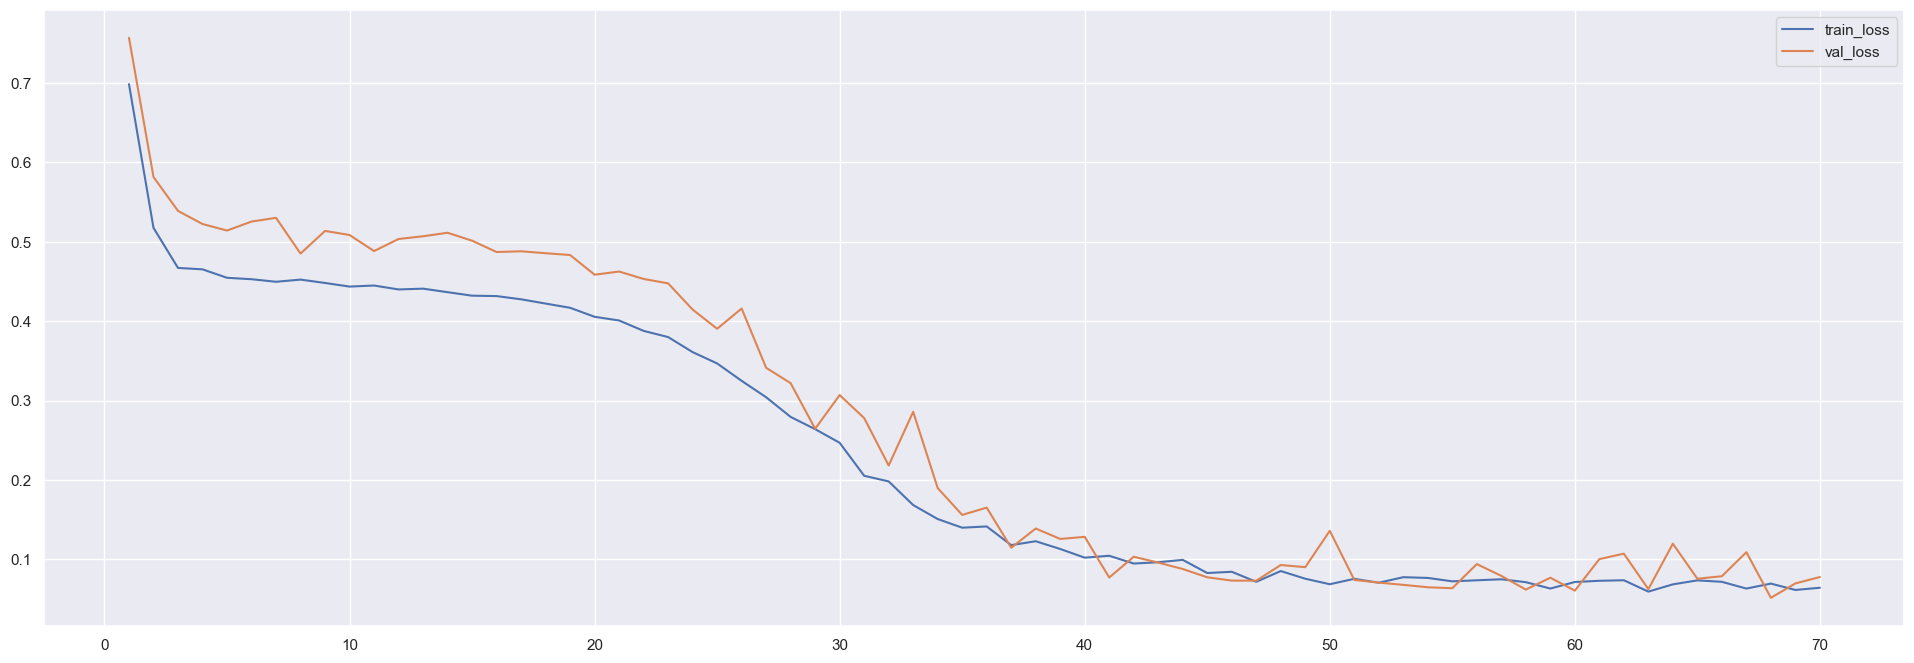

In [82]:
%%time
# Create GraphSAGE
print(model)

# Train
model.fit(loader, NUM_EPOCH, optimizer, criterion, scorer)
my_plot(NUM_EPOCH, model.total_loss, model.val_loss)

# Test
pred, test_score = test_model(model, data, data.test_mask, scorer)
print(f'\nGraphSAGE-alike test score {scorer.__name__}: {test_score:.3f}\n')

### Show results

In [78]:
df_compare_pred = pd.concat([test[TARGET], pd.Series(pred.detach().numpy(), name="pred")], axis=1)
df_compare_pred.head(5)

,target,pred
0,0.279231,0.296163
1,0.380795,0.318607
2,0.686527,0.738698
3,0.303594,0.315371
4,0.367374,0.283601


<Axes: >

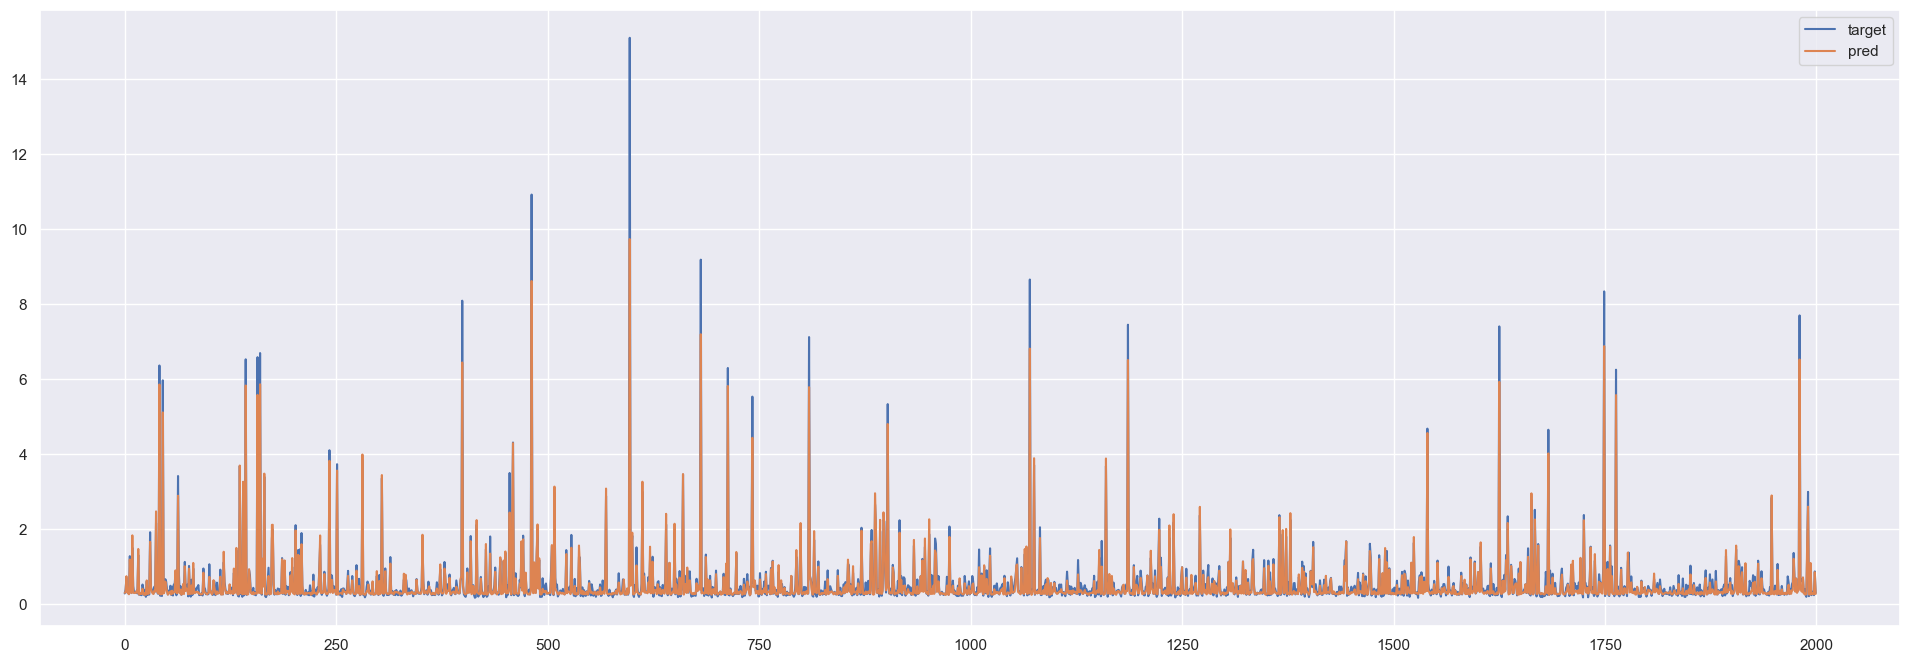

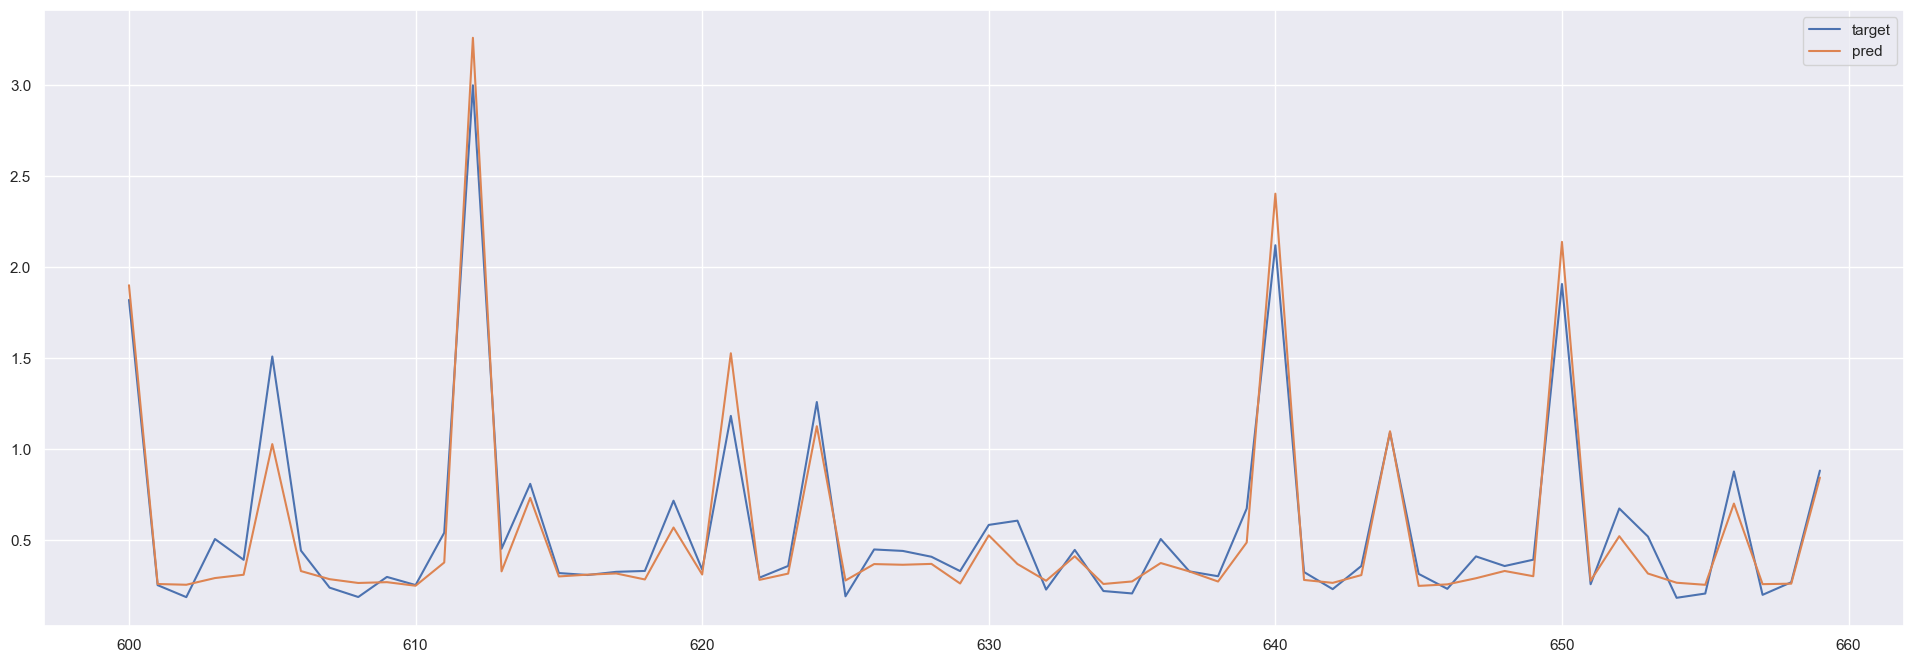

In [79]:
df_compare_pred.plot()
df_compare_pred[600:660].plot()

# 9. Outcome

1. For unknown reasons features and target transformation influence bad on prediciton result.
2. Prediction model based on Neural network are much better than Base dummy model.
3. Train and validation loss functions (depending on `epoch`) are close to each other. Therefore generalization property of the model are `good`. To have it it was added several `dropout` with high value `0.5`, `lr` and `weight decay` was reduced.
4. It is observed that after `epoch > 50` model tends to have a plato.
5. Train, validation and test values are very close to each other. Therefore `MSE=0.041` looks stable.